In [13]:
import os
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
import sklearn

from helper import load_data
df_meta, all_codes = load_data(r"/Users/tom.jubb/Documents/data/us_census/", verbose=False)

In [57]:
def describe_feature(x): 
    v = df_meta[df_meta['Var'] == x]['Description'].values
    if len(v) == 0:
        return ''
    else:
        return v[0]
    
def combine_rare_classes(df, col, r=0.1, map_to='other'):
    
    gb = df[[col]].copy()
    gb['count'] = 1
    gb = gb[[col, 'count']].copy().groupby(col).sum().reset_index().sort_values(col, ascending=False)
    gb['count'] = 100*gb['count'] / sum(gb['count'])
    
    mapper = {k:map_to for k in gb[gb['count'] < r][col].values}

    return mapper, gb


def load_data(target='REARNING', 
              age_range = [18,90],
              wage_range = [5000,140000],
             retain: int = 100):
    
    df = pd.read_csv('us_census_data_cleaned_5.csv').drop('Unnamed: 0', axis=1)
    # provide some sensible bounds

    TARGET = 'REARNING'

    # exclude irrelevant data
    assert age_range[0] < age_range[1]
    df = df[df['AGE']      > age_range[0]]
    df = df[df['AGE']      < age_range[1]]

    assert wage_range[0] < wage_range[1]
    df = df[df['REARNING'] > wage_range[0]]
    df = df[df['REARNING'] < wage_range[1]]
    
    mapper, gb = combine_rare_classes(df, 'RACE', 2.0, map_to = 'Other Race 700 799, 986 999')
    df['RACE'] = df['RACE'].apply(lambda x: mapper.get(x, x))
    
    uninformative_columns = []
    for c in df.columns:
        if len(df[c].unique()) == 1:
            print(c)
            uninformative_columns += [c]
    df = df.drop(uninformative_columns, axis=1)
    
    if retain<100:
        df = df.iloc[:int(retain * df.sahpe[0]),:]
    
    return df

def _prepare_data(df, 
                  target  = 'REARNING', 
                  cols        = None, 
                  cat_cols    = None, 
                  encode_cats = True,
                  verbose     = True):
    
    if cols is None:
        cols = df.columns
    
    categorical_features = []
    if cat_cols is not None:
        categorical_features = cat_cols #[c for c in cats if c in cols]

    valid_cols = [c for c in cols if c in df.columns]
    df_X = df[valid_cols].copy()
    for c in df_X.columns:
        df_X[c] = df_X[c].astype(float, errors='ignore')
    assert target in df_X.columns

    feature_names = [x for x in list(df_X.columns) if x!=target]

    # ordinal encode the categorical features
    le_fitted ={}
    if encode_cats:
        for feature in categorical_features:
            le                 = preprocessing.LabelEncoder()
            le_fitted[feature] = le.fit(df_X[feature].values)
            df_X[feature]      = le_fitted[feature].transform(df_X[feature])
    
        if verbose and len(categorical_features)>0:
            print("Cardinalities")
            print("=============")
            for c in categorical_features:
                print(f"{c:<25} : {len(le_fitted[c].classes_)}")
            
    return df_X, le_fitted

def _split_data(df_X, target, scaler=None, shuffle=True):
    
    X = np.array(df_X.drop(target, axis=1), dtype=float)
    y = np.array(df_X[target], dtype=float)
    
    if shuffle:
            X, y = sklearn.utils.shuffle(X, y)

    n = X.shape[0]
    n_test = int(n*0.05)
    
    if scaler:
        scaler.fit(X)
        X = scaler.transform(X)

    X_train = X[n_test:,:]
    y_train = y[n_test:]

    X_test = X[:n_test,:]
    y_test = y[:n_test]
    
    return X_train, y_train, X_test, y_test


def _regression_metrics(model, X_test, y_test, verbose=True):
    results = {}
    # how did we do?
    results['score'] =model.score(X_test, y_test) 
    if verbose:
        print(f"Score                          : {results['score']:.2f}")

    # the mean error on prediction
    results['mean_abs_err'] = np.abs(model.predict(X_test) - y_test).mean()
    if verbose:
        print(f"Average Error                  : ${results['mean_abs_err']:.0f}")

    r = (model.predict(X_test) > 50000) == (y_test > 50000)
    results['class_err'] = 100 * sum(r) / len(r)
    if verbose:
        print(f"Classification (>$50,000) acc. : {results['class_err']:.2f}")
    
    return results

In [60]:
NUM_FEATURES = [
    'AGE',
    'YEARWRK',
    'FERTIL',
    'HOUR89',
    'HOURS',
    'RIDERS',
    'WEEK89', 
    'TRAVTIME',
    'YRSSERV',
    'REARNING',
    'INCOME1',
    'PWGT1',
    'DEPART',
    'RIDERS',
    'TRAVTIME'
]

from typing import Optional

def _validate_features(df, 
                       target_feature: str, 
                       keep_features: Optional[list] = None, 
                       drop_features: Optional[list] = None):
    
    all_features = df.columns
   
    if keep_features is None:
        # default to keep all features
        keep_features = all_features
    if drop_features is None:
        # default to drop nothing
        drop_features = []

    if target_feature not in all_features:
        print(f"WARNING : target feature {target_feature} not found in data")
        raise RuntimeError(f"WARNING : target feature {target_feature} not found in data")
        
    keep_f = list(set(keep_features))
    drop_f = list(set(drop_features))
        
    if target_feature in keep_f:
        print(f"WARNING : target feature {target_feature} is in keep_feature list, it is not an input feature")
        keep_f.remove(target_feature)
        
    if target_feature in drop_f:
        print(f"WARNING : target feature {target_feature} is in drop_features list, it cannot be dropped")
        drop_f.remove(target_feature)
    
    for feature in drop_f:
        if feature in keep_f:
            print(f"WARNING : keep feature {feature} is also in drop_features!")
            keep_f.remove(feature)
    
    for feature in keep_f:
        if feature not in all_features:
            print(f"WARNING : keep feature {feature} is not in the data!")
            keep_f.remove(feature)
            
    df = df[keep_f + [target_feature]]
    
#     if len(drop_f)>0:
#         df = df.drop(drop_f, axis=1)
    
    features = list(df.columns)
#     features.remove(target_feature)
    
    return df, features
    
def print_features(df):
    print("===== FEATURE LIST ======")
    for x in list(df.columns):
        try:
            vartype = 'NUM' if x in NUM_FEATURES else 'CAT'
            if vartype == 'CAT':
                card = len(df[x].unique())
                print(f"{x:<20} - {vartype} - {card:<4} - {describe_feature(x)}")
            else:
                print(f"{x:<20} - {vartype} -      - {describe_feature(x)}")
        except:
            print(x)

In [81]:
def train_linear_regression(df, 
                            target_feature,
                            keep_features = [],
                            drop_features = [],
                            model_name="linearRegression",
                            model_params={},
                            n_repeats=10, 
                            test_split=0.05,
                            encode_cats=True,
                            scale=True,
                            verbose=True):
    
    df, features = _validate_features(df, target_feature, keep_features, drop_features)
    if verbose:
        print_features(df)
    
    print("="*100)
    print("====== PREPARING DATA ============")
    print("="*100 + '\n')
    
    if scale:
        scaler = StandardScaler()
    else:
        scaler = None
    
    cat_features = [c for c in features if c not in NUM_FEATURES]
    df_X, _ = _prepare_data(df, 
                        target      = target_feature, 
                        cols        = features, 
                        cat_cols    = cat_features, 
                        encode_cats = encode_cats,
                        verbose     = verbose)
    print(f"Rows          : {df_X.shape[0]} Features: {df_X.shape[1]}")

    X_train, y_train, X_test, y_test = _split_data(df_X, target=target_feature, scaler=scaler)
    print(f"Training data : {X_train.shape[0]} \nTest data     : {X_test.shape[0]}")
    
    print("="*100)
    print("====== TRAINING MODELS ============")
    print("="*100 + '\n')
    
    results = []
    coefs   = []
    models  = []
    
    model_obj = {"linearRegression":LinearRegression,
                 "gradientBoostedTree":GradientBoostingRegressor}[model_name]
    for i in range(n_repeats):
        model = model_obj(**model_params)
        
        print(fr"{i}/{n_repeats}", end='\r')
        X_train, y_train, X_test, y_test = _split_data(df_X, 
                                                       target=target_feature, 
                                                       scaler=scaler, 
                                                       shuffle=True)
        reg      = model.fit(X_train, y_train)
        coefs   += [reg.coef_]
        results += [_regression_metrics(reg, X_test, y_test, verbose=False)]
        models  += [model]

    err = [r['mean_abs_err'] for r in results]
    
    print("="*100)
    print("====== TESTING MODELS ============")
    print("="*100 + '\n')
    
    print(f"Error : ${np.mean(err):.2f} +/- {np.std(err):.2f}")
    
    
    xvals_ = [c for c in df_X.columns if c != target_feature]
    yvals_, yvals_err_ = np.array(coefs).mean(axis=0), np.array(coefs).std(axis=0)

    fig, ax = plt.subplots(1,1,figsize=(20,6))

    # yvals_ = reg.coef_
    idx = np.argsort(np.abs(yvals_))[::-1]
    xvals     = np.array([xvals_[i] for i in idx])
    yvals     = np.array([yvals_[i] for i in idx])
    yvals_err = np.array([yvals_err_[i] for i in idx])

    plt.scatter(xvals, yvals - yvals_err, color="black", s=10)
    plt.scatter(xvals, yvals + yvals_err, color="black", s=10)

    plt.plot([0,df_X.shape[1]-1],[0,0], color="gray", ls=":")
    for c, coef in zip(xvals, yvals):
        color = 'g' if coef>0 else 'r'
        plt.plot([c,c],[0,coef], color=color)

    plt.xticks(rotation=90)
    plt.show()

    print('\n')
    print("MOST IMPORTANT FEATURES\n")
    for i in np.where((reg.coef_ > 2000) | (reg.coef_ < -2000))[0]:
        col_name = df_X.drop(target_feature, axis=1).columns[i]
        description = describe_feature(col_name)
        print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")


    print('\n')
    print("LEAST IMPORTANT FEATURES\n")
    for i in np.where(abs(reg.coef_) < 50 )[0]:
        col_name = df_X.drop(target_feature, axis=1).columns[i]
        description = describe_feature(col_name)
        print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")

    # TODO : return best model
    return model
        
def train_decision_trees(df, 
                            target_feature,
                            keep_features = [],
                            drop_features = [],
                            model_params={},
                            n_repeats=10, 
                            test_split=0.05,
                            encode_cats=True,
                            scale=True,
                            verbose=True):
    
    df, features = _validate_features(df, target_feature, keep_features, drop_features)
    if verbose:
        print_features(df)
    
    print("="*100)
    print("====== PREPARING DATA ============")
    print("="*100 + '\n')
    
    if scale:
        scaler = StandardScaler()
    else:
        scaler = None
    
    cat_features = [c for c in features if c not in NUM_FEATURES]
    df_X, _ = _prepare_data(df, 
                        target      = target_feature, 
                        cols        = features, 
                        cat_cols    = cat_features, 
                        encode_cats = encode_cats,
                        verbose     = verbose)
    print(f"Rows          : {df_X.shape[0]} Features: {df_X.shape[1]}")

    X_train, y_train, X_test, y_test = _split_data(df_X, target=target_feature, scaler=scaler)
    print(f"Training data : {X_train.shape[0]} \nTest data     : {X_test.shape[0]}")
    
    print("="*100)
    print("====== TRAINING MODELS ============")
    print("="*100 + '\n')
    
    results = []
    coefs   = []
    models  = []
    
    model_obj = GradientBoostingRegressor
    for i in range(n_repeats):
        model = model_obj(**model_params)
        
        print(fr"{i}/{n_repeats}", end='\r')
        X_train, y_train, X_test, y_test = _split_data(df_X, 
                                                       target=target_feature, 
                                                       scaler=scaler, 
                                                       shuffle=True)
        reg      = model.fit(X_train, y_train)
        results += [_regression_metrics(reg, X_test, y_test, verbose=False)]
        models  += [model]

    err = [r['mean_abs_err'] for r in results]
    
    print("="*100)
    print("====== TESTING MODELS ============")
    print("="*100 + '\n')
    
    print(f"Error : ${np.mean(err):.2f} +/- {np.std(err):.2f}")

   
    # TODO : return best model
    return model

def train_neural_network(df):
    pass

# Training

In [70]:
df = load_data(target    = 'REARNING', 
              age_range  = [18,90],
              wage_range = [5000,140000], 
              retain     = 100)

ROWNCHLD
WORK89


===== FEATURE LIST ======
HISPANIC             - CAT - 56   - Detailed Hispanic Origin Code See Append
OTHRSERV             - CAT - 2    - Served Any Other Time
AGE                  - NUM -      - Age
FERTIL               - NUM -      - No. of Chld. Ever Born
DISABL1              - CAT - 2    - Work Limitation Stat.
HOUR89               - NUM -      - Usual Hrs. Worked Per Week Last Yr. 1989
ANCSTRY2             - CAT - 192  - Ancestry Second Entry See Appendix I Anc
INDUSTRY             - CAT - 243  - Ind. See Appendix I Ind..lst
SEX                  - CAT - 2    - Sex
OCCUP_MAJ            - CAT - 14   - 
LANG1                - CAT - 2    - Language Other Than English At Home
FEB55                - CAT - 2    - Served February 1955 July 1964
MILITARY             - CAT - 2    - Military Srvc.
MARITAL              - CAT - 5    - Marital Stat.
OCCUP                - CAT - 504  - Occupation See Appendix I Occup.lst
KOREAN               - CAT - 2    - Served Korean Conflict June 1950 Janua

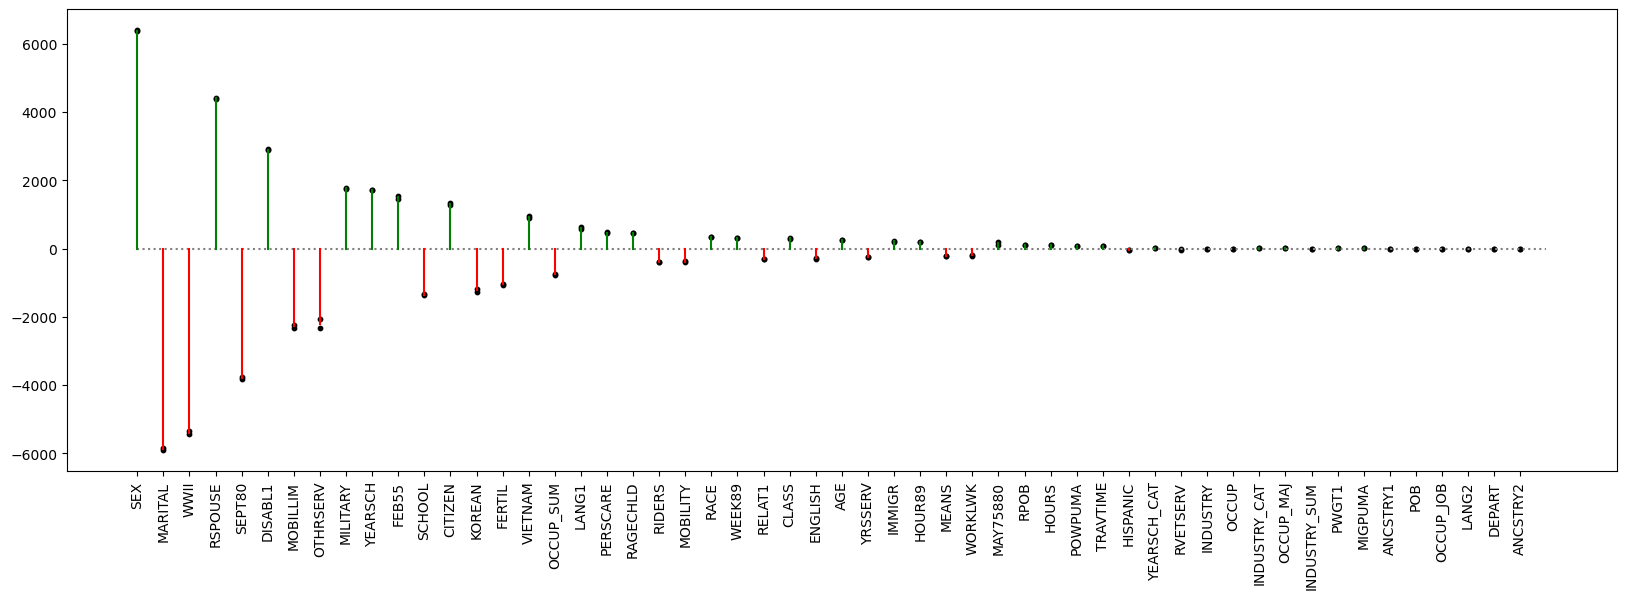



MOST IMPORTANT FEATURES

OTHRSERV   -2354.66   Served Any Other Time
DISABL1    2904.27    Work Limitation Stat.
SEX        6372.74    Sex
MARITAL    -5910.02   Marital Stat.
WWII       -5482.00   Served World War II September 1940 July
SEPT80     -3799.19   Served September 1980 or Later
RSPOUSE    4429.03    Married. Spouse Present/spouse Absent
MOBILLIM   -2229.15   Mobility Limitation


LEAST IMPORTANT FEATURES

HISPANIC   -37.67     Detailed Hispanic Origin Code See Append
ANCSTRY2   -0.22      Ancestry Second Entry See Appendix I Anc
INDUSTRY   -19.08     Ind. See Appendix I Ind..lst
OCCUP_MAJ  11.07      
OCCUP      -18.33     Occupation See Appendix I Occup.lst
PWGT1      8.26       Pers. Wgt
OCCUP_JOB  1.26       
RVETSERV   -13.16     Veteran Per. of Srvc.
LANG2      0.80       Language Spoken At Home See Appendix I L
MIGPUMA    7.55       Migration Puma State Dependent
YEARSCH_CAT 25.80      
POB        -4.17      Place of Birth Appendix I Birth.lst Unit
INDUSTRY_SUM -9.22

In [71]:
model = train_linear_regression(df, 
                        target_feature ='REARNING',
                        keep_features  = None,
                        drop_features  = ['MIGSTATE','POWSTATE'],
                        n_repeats      = 10, 
                        test_split     = 0.05,
                        encode_cats    = True,
                        scale          = False,
                        verbose        = True)

In [ ]:
model = train_decision_trees(df, 
                        target_feature ='REARNING',
                        keep_features  = None,
                        drop_features  = ['MIGSTATE','POWSTATE'],
                        n_repeats      = 1, 
                        model_params   = {"n_estimators":200, "max_depth":9, "learning_rate":0.25},
                        test_split     = 0.05,
                        encode_cats    = True,
                        scale          = False,
                        verbose        = True)

===== FEATURE LIST ======
HISPANIC             - CAT - 56   - Detailed Hispanic Origin Code See Append
OTHRSERV             - CAT - 2    - Served Any Other Time
AGE                  - NUM -      - Age
FERTIL               - NUM -      - No. of Chld. Ever Born
DISABL1              - CAT - 2    - Work Limitation Stat.
HOUR89               - NUM -      - Usual Hrs. Worked Per Week Last Yr. 1989
ANCSTRY2             - CAT - 192  - Ancestry Second Entry See Appendix I Anc
INDUSTRY             - CAT - 243  - Ind. See Appendix I Ind..lst
SEX                  - CAT - 2    - Sex
OCCUP_MAJ            - CAT - 14   - 
LANG1                - CAT - 2    - Language Other Than English At Home
FEB55                - CAT - 2    - Served February 1955 July 1964
MILITARY             - CAT - 2    - Military Srvc.
MARITAL              - CAT - 5    - Marital Stat.
OCCUP                - CAT - 504  - Occupation See Appendix I Occup.lst
KOREAN               - CAT - 2    - Served Korean Conflict June 1950 Janua

## Testing

In [78]:
GradientBoostingRegressor(**{"max_iter":200, "max_depth":9, "learning_rate":0.25})

TypeError: __init__() got an unexpected keyword argument 'max_iter'